# Camera Based Occupancy Sensing

## Function to save Plots

In [1]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Split Dataset into Train/Validation/Test Sections

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(source_dir, dest_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1, "Train, val and test ratios must sum to 1."

    # Create destination directories
    for subset in ['train', 'val', 'test']:
        for class_name in ['yes', 'no']:
            os.makedirs(os.path.join(dest_dir, subset, class_name), exist_ok=True)
    
    # Split and copy files
    for class_name in ['yes', 'no']:
        class_path = os.path.join(source_dir, class_name)
        files = os.listdir(class_path)
        
        train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

        for file_set, subset in zip([train_files, val_files, test_files], ['train', 'val', 'test']):
            for file in file_set:
                src = os.path.join(class_path, file)
                dst = os.path.join(dest_dir, subset, class_name, file)
                shutil.copy(src, dst)
                
    print('Dataset splitted successfully.')

source_dir = 'Dataset/'
dest_dir = 'Dataset/'
split_data(source_dir, dest_dir)

Dataset splitted successfully.


## Plot: Number of Images per Class Used for the System Development

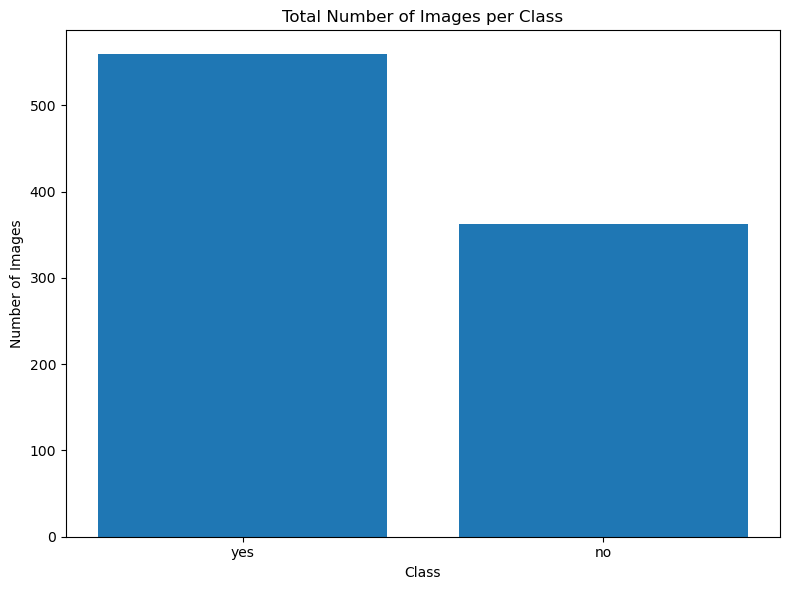

In [3]:
import os
import matplotlib.pyplot as plt

source_dir = 'Dataset/'
class_counts = {}

# List the folders (classes)
classes = ['yes', 'no']

for class_name in classes:
    class_dir = os.path.join(source_dir, class_name)
    class_counts[class_name] = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])

# Plotting the counts
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class')
save_fig('Total Number of Images per Class')
plt.show()

## Plot: Images count per set

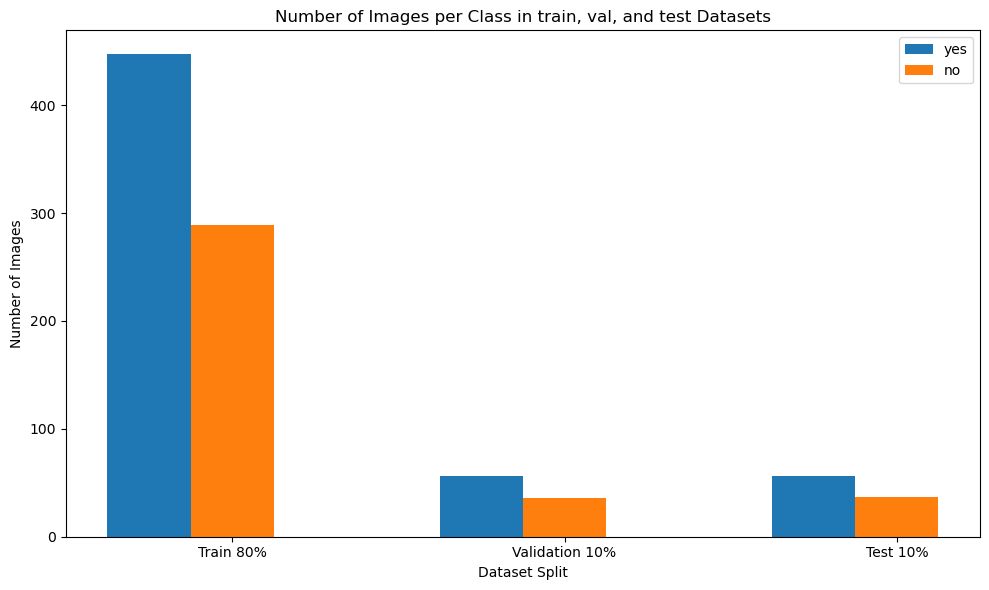

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# directories
directories = {
    'train': 'Dataset/train',
    'val': 'Dataset/val',
    'test': 'Dataset/test'
}

all_counts = {'yes': [], 'no': []}

# Loop over the directories and classes
for dir_name, source_dir in directories.items():
    for class_name in all_counts.keys():
        class_dir = os.path.join(source_dir, class_name)
        # Count the number of images in the class folder
        count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
        all_counts[class_name].append(count)

# Plotting the counts for each directory using bars
x_labels = ['Train 80%', 'Validation 10%', 'Test 10%']
x = np.arange(len(x_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each class
for i, (class_name, counts) in enumerate(all_counts.items()):
    ax.bar(x + i*width, counts, width, label=class_name)

# Plot configs
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in train, val, and test Datasets')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.legend()

# plt.grid(True)
save_fig('Train-Val-Test Count Plot')
plt.show()

## Pre-processing Section

### Dataloader Pipeline

In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_train_val_test_dataloaders(data_dir, batch_size, num_workers=4):
    # Define specific transformations for each dataset
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Create datasets using specific transformations
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
    }

    return dataloaders

### Switching to GPU Utilization Mood

In [6]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Define CNN Models

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def load_resnet50(num_classes):
    model =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def load_efficientnet_b0(num_classes):
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v2(num_classes):
    model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v3_large(num_classes):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v3_small(num_classes):
    model = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

### Model Training Section

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

class ModelTrainer:
    def __init__(self, model, dataloaders, criterion, optimizer, num_epochs, save_dir):
        self.model = model
        self.dataloaders = dataloaders
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.save_dir = save_dir
        
        # Lists to store loss and accuracy values
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self):
        # Create directory for saving models if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)

        train_loader = self.dataloaders['train']
        val_loader = self.dataloaders['val']

        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} - Training'):
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs).squeeze(1)  # Output shape: [batch_size], squeeze to remove extra dimension
                loss = self.criterion(outputs, labels.float())  # Convert labels to float for BCEWithLogitsLoss
                loss.backward()
                self.optimizer.step()

                running_train_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                predicted = torch.round(torch.sigmoid(outputs))  # Get the predicted class
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_train_loss / len(train_loader.dataset)
            train_acc = correct_train / total_train

            # Validation phase
            self.model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} - Validation'):
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = self.model(inputs).squeeze(1)
                    loss = self.criterion(outputs, labels.float())

                    running_val_loss += loss.item() * inputs.size(0)

                    # Calculate accuracy
                    predicted = torch.round(torch.sigmoid(outputs))  # Get the predicted class
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val / total_val

            # Store loss and accuracy values
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch statistics
            print(f'Epoch [{epoch+1}/{self.num_epochs}] - '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

            # Save the model after each epoch
            torch.save(self.model.state_dict(), os.path.join(self.save_dir, f'model_epoch_{epoch+1}.pth'))

        print('Training complete.')

    def plot_learning_curves(self, fig_name):
        plt.figure(figsize=(12, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Train Loss')
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.train_accuracies) + 1), self.train_accuracies, label='Train Accuracy')
        plt.plot(range(1, len(self.val_accuracies) + 1), self.val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()

        plt.tight_layout()
        plt.savefig(fig_name)
        plt.show()

### Train: ResNet50

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch [1/10] - Train Loss: 0.3684, Train Acc: 83.97%, Val Loss: 13.8639, Val Acc: 63.04%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [2/10] - Train Loss: 0.2906, Train Acc: 90.22%, Val Loss: 0.5040, Val Acc: 82.61%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch [3/10] - Train Loss: 0.2385, Train Acc: 90.22%, Val Loss: 0.2361, Val Acc: 92.39%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch [4/10] - Train Loss: 0.1346, Train Acc: 95.65%, Val Loss: 0.7143, Val Acc: 72.83%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch [5/10] - Train Loss: 0.1090, Train Acc: 97.28%, Val Loss: 0.1726, Val Acc: 94.57%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch [6/10] - Train Loss: 0.1319, Train Acc: 95.11%, Val Loss: 1.0937, Val Acc: 83.70%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [7/10] - Train Loss: 0.2486, Train Acc: 91.71%, Val Loss: 0.6650, Val Acc: 86.96%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch [8/10] - Train Loss: 0.1535, Train Acc: 95.11%, Val Loss: 0.5170, Val Acc: 83.70%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch [9/10] - Train Loss: 0.0741, Train Acc: 97.69%, Val Loss: 0.1564, Val Acc: 93.48%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch [10/10] - Train Loss: 0.0272, Train Acc: 98.91%, Val Loss: 0.2593, Val Acc: 92.39%
Training complete.


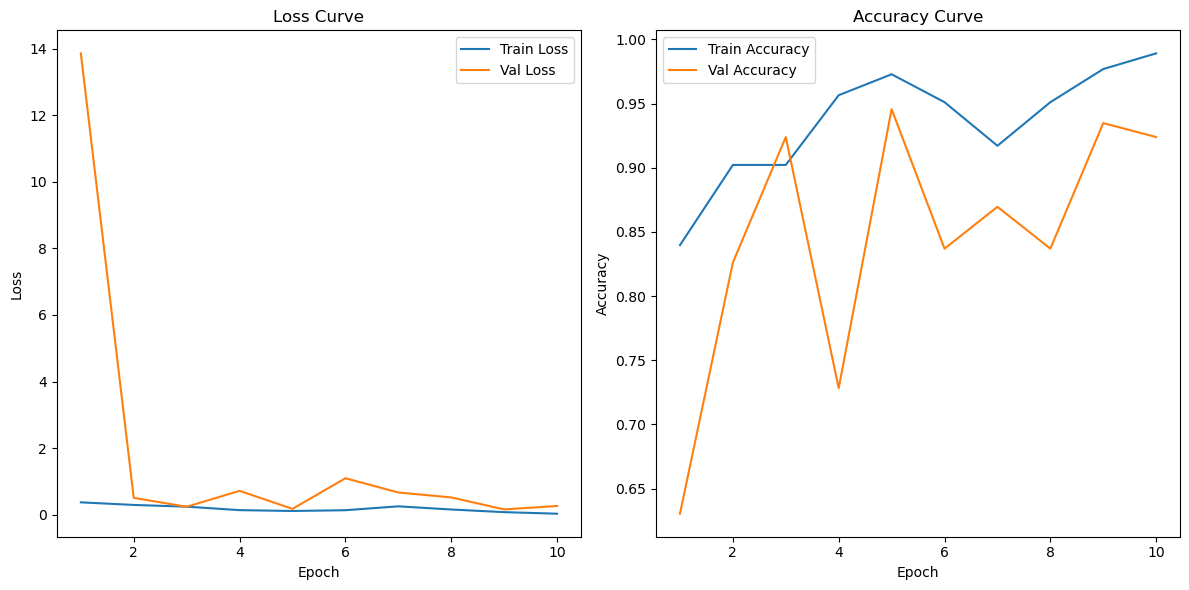

In [10]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_resnet50(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/resnet50'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_resnet50')

### Train: Mobilenet_v3_large

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch [1/10] - Train Loss: 0.3529, Train Acc: 86.55%, Val Loss: 0.2864, Val Acc: 89.13%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch [2/10] - Train Loss: 0.1358, Train Acc: 95.52%, Val Loss: 0.7441, Val Acc: 86.96%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch [3/10] - Train Loss: 0.0673, Train Acc: 97.42%, Val Loss: 0.7564, Val Acc: 85.87%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [4/10] - Train Loss: 0.0510, Train Acc: 98.10%, Val Loss: 0.8052, Val Acc: 86.96%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch [5/10] - Train Loss: 0.0210, Train Acc: 99.05%, Val Loss: 0.5025, Val Acc: 91.30%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch [6/10] - Train Loss: 0.0223, Train Acc: 98.64%, Val Loss: 1.5926, Val Acc: 85.87%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch [7/10] - Train Loss: 0.0661, Train Acc: 97.55%, Val Loss: 2.0554, Val Acc: 80.43%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch [8/10] - Train Loss: 0.0513, Train Acc: 98.23%, Val Loss: 3.7592, Val Acc: 71.74%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch [9/10] - Train Loss: 0.0459, Train Acc: 98.37%, Val Loss: 0.5644, Val Acc: 91.30%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch [10/10] - Train Loss: 0.0449, Train Acc: 98.78%, Val Loss: 1.0016, Val Acc: 85.87%
Training complete.


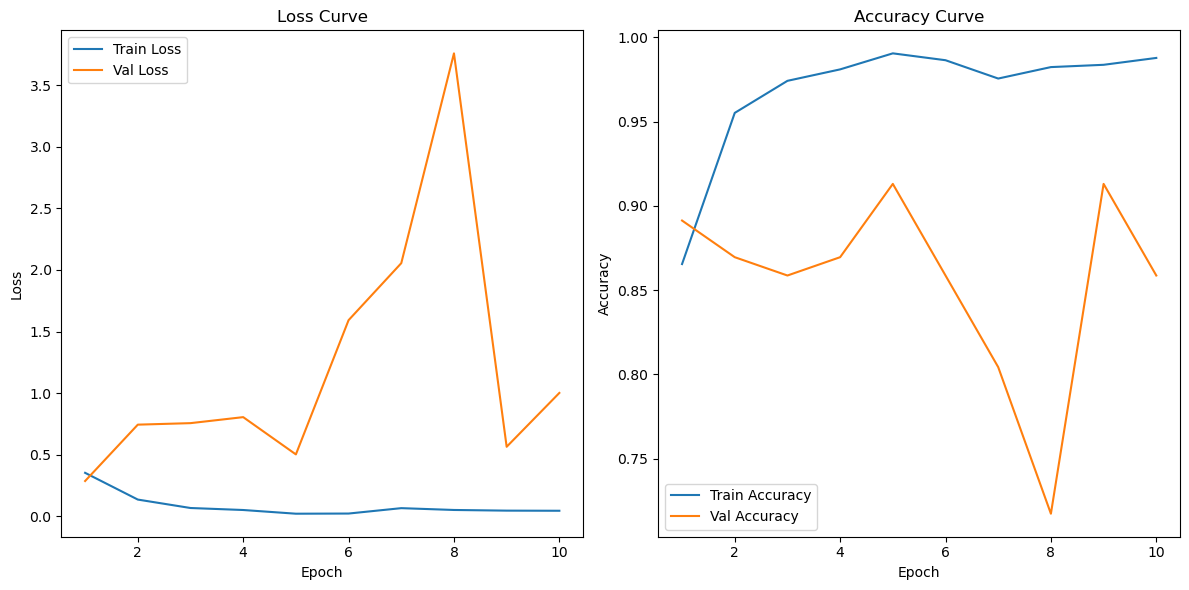

In [11]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v3_large(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/mobilenet_v3_large'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v3_large')

### Train: Efficientnet_b0

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch [1/10] - Train Loss: 0.3253, Train Acc: 85.87%, Val Loss: 1.0128, Val Acc: 82.61%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch [2/10] - Train Loss: 0.1241, Train Acc: 94.70%, Val Loss: 0.2827, Val Acc: 93.48%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [3/10] - Train Loss: 0.0892, Train Acc: 96.33%, Val Loss: 0.2066, Val Acc: 94.57%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch [4/10] - Train Loss: 0.1139, Train Acc: 95.52%, Val Loss: 0.2195, Val Acc: 91.30%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch [5/10] - Train Loss: 0.0822, Train Acc: 97.42%, Val Loss: 0.1242, Val Acc: 97.83%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [6/10] - Train Loss: 0.0527, Train Acc: 98.78%, Val Loss: 0.2116, Val Acc: 92.39%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch [7/10] - Train Loss: 0.0624, Train Acc: 98.78%, Val Loss: 0.1033, Val Acc: 95.65%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch [8/10] - Train Loss: 0.0491, Train Acc: 97.96%, Val Loss: 0.1639, Val Acc: 94.57%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [9/10] - Train Loss: 0.0296, Train Acc: 98.78%, Val Loss: 0.1005, Val Acc: 96.74%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch [10/10] - Train Loss: 0.0166, Train Acc: 99.18%, Val Loss: 0.1205, Val Acc: 94.57%
Training complete.


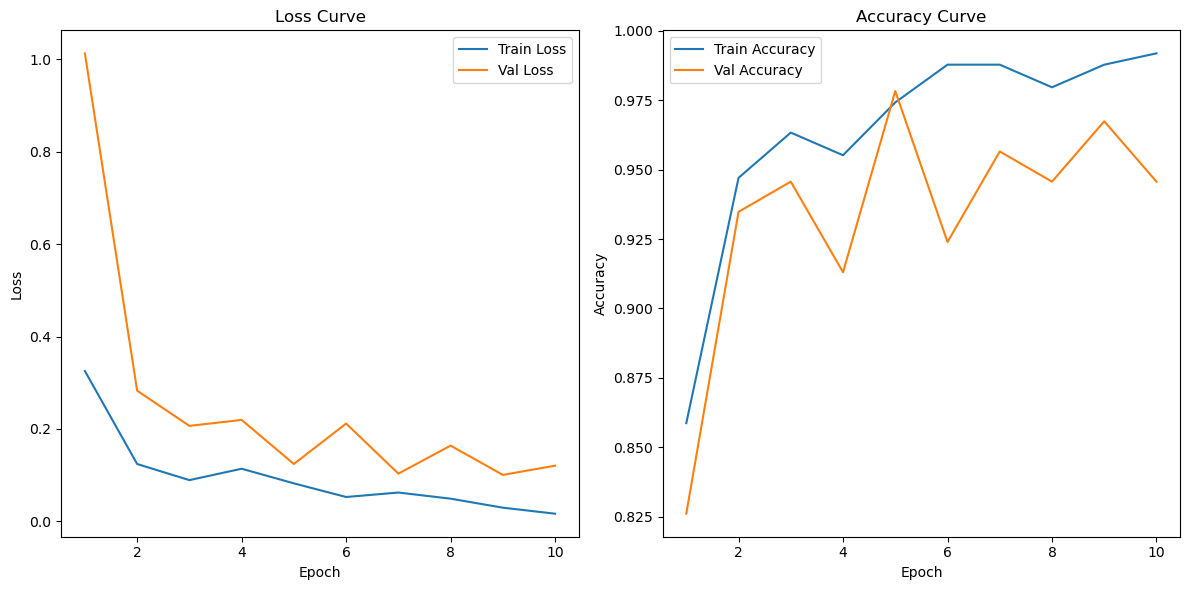

In [12]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_efficientnet_b0(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/efficientnet_b0'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_efficientnet_b0p')

### Train: MobileNet_v2

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch [1/10] - Train Loss: 0.3244, Train Acc: 86.41%, Val Loss: 0.1220, Val Acc: 96.74%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch [2/10] - Train Loss: 0.1170, Train Acc: 97.42%, Val Loss: 0.1120, Val Acc: 96.74%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch [3/10] - Train Loss: 0.0444, Train Acc: 98.37%, Val Loss: 0.1533, Val Acc: 92.39%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch [4/10] - Train Loss: 0.0735, Train Acc: 97.42%, Val Loss: 0.1879, Val Acc: 94.57%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [5/10] - Train Loss: 0.0397, Train Acc: 98.10%, Val Loss: 0.0642, Val Acc: 96.74%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch [6/10] - Train Loss: 0.0283, Train Acc: 99.05%, Val Loss: 0.0429, Val Acc: 98.91%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [7/10] - Train Loss: 0.0412, Train Acc: 98.10%, Val Loss: 0.0483, Val Acc: 97.83%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [8/10] - Train Loss: 0.1238, Train Acc: 96.06%, Val Loss: 0.5443, Val Acc: 89.13%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch [9/10] - Train Loss: 0.0938, Train Acc: 96.88%, Val Loss: 0.0670, Val Acc: 96.74%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch [10/10] - Train Loss: 0.0556, Train Acc: 98.37%, Val Loss: 0.2573, Val Acc: 90.22%
Training complete.


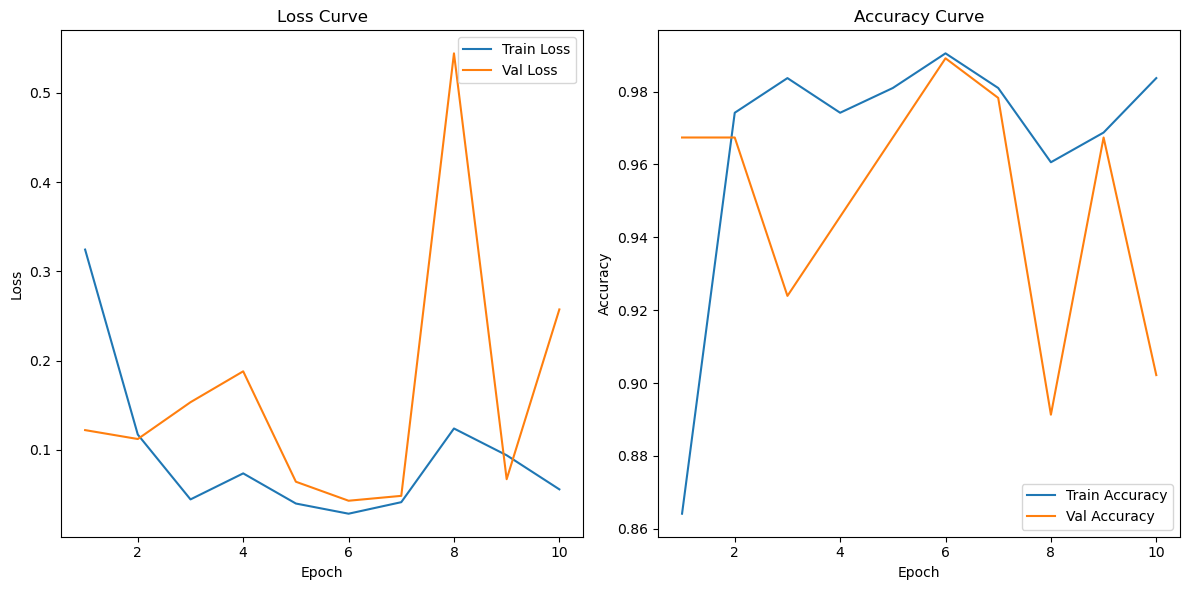

In [13]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v2(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/mobilenet_v2'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v2')

### Train: MobileNet_v3_small

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch [1/10] - Train Loss: 0.4015, Train Acc: 80.03%, Val Loss: 2.4645, Val Acc: 71.74%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch [2/10] - Train Loss: 0.1423, Train Acc: 94.43%, Val Loss: 0.7520, Val Acc: 85.87%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch [3/10] - Train Loss: 0.0405, Train Acc: 98.23%, Val Loss: 0.3807, Val Acc: 91.30%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch [4/10] - Train Loss: 0.0520, Train Acc: 98.10%, Val Loss: 0.5717, Val Acc: 90.22%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch [5/10] - Train Loss: 0.0546, Train Acc: 97.55%, Val Loss: 0.9777, Val Acc: 83.70%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch [6/10] - Train Loss: 0.0419, Train Acc: 98.23%, Val Loss: 0.9463, Val Acc: 83.70%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch [7/10] - Train Loss: 0.0508, Train Acc: 97.96%, Val Loss: 0.3602, Val Acc: 88.04%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch [8/10] - Train Loss: 0.0634, Train Acc: 97.69%, Val Loss: 0.5198, Val Acc: 89.13%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch [9/10] - Train Loss: 0.0402, Train Acc: 98.51%, Val Loss: 0.3125, Val Acc: 90.22%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch [10/10] - Train Loss: 0.0146, Train Acc: 99.46%, Val Loss: 0.4131, Val Acc: 90.22%
Training complete.


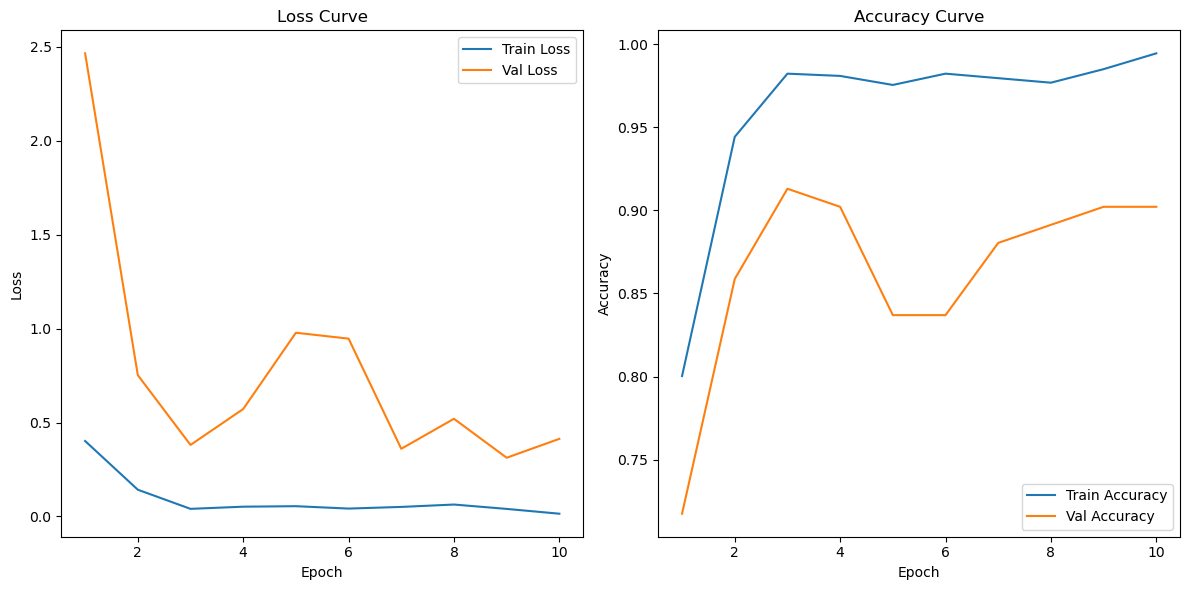

In [14]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v3_small(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/mobilenet_v3_small'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v3_small')

## Model Testing Section

In [15]:
import torch

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
!pip install scikit-plot

### Load Test Dataset

In [16]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_test_dataloader(data_dir, batch_size, num_workers=4):
    # Define transformations for the test dataset
    data_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create the test dataset
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transform)

    # Create the test dataloader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

data_dir = 'Dataset/'
batch_size = 32
test_loader = create_test_dataloader(data_dir, batch_size)

In [35]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

def evaluate_model(model, test_loader, criterion, save_path):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)  # Output shape: [batch_size]
            loss = criterion(outputs, labels.float())  # Convert labels to float

            test_loss += loss.item() * inputs.size(0)

            # Apply sigmoid activation and classify based on threshold 0.5
            predicted = (torch.sigmoid(outputs) >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

    # Generate confusion matrix
    skplt.metrics.plot_confusion_matrix(all_labels,all_predictions)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    save_fig(save_path)

In [36]:
# List of model loading functions
model_functions = [
    load_resnet50,
    load_mobilenet_v3_large,
    load_efficientnet_b0,
    load_mobilenet_v2,
    load_mobilenet_v3_small,
]

checkpoint_paths = [
    'Checkpoints/resnet50/model_epoch_9.pth',
    'Checkpoints/mobilenet_v3_large/model_epoch_9.pth',
    'Checkpoints/efficientnet_b0/model_epoch_9.pth',
    'Checkpoints/mobilenet_v2/model_epoch_6.pth',
    'Checkpoints/mobilenet_v3_small/model_epoch_9.pth',
]

Checkpoints/resnet50/model_epoch_9.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


Test Loss: 0.3327, Test Accuracy: 90.32%
Checkpoints/mobilenet_v3_large/model_epoch_9.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


Test Loss: 1.6614, Test Accuracy: 86.02%
Checkpoints/efficientnet_b0/model_epoch_9.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


Test Loss: 0.2327, Test Accuracy: 93.55%
Checkpoints/mobilenet_v2/model_epoch_6.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


Test Loss: 0.3701, Test Accuracy: 94.62%
Checkpoints/mobilenet_v3_small/model_epoch_9.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


Test Loss: 0.4707, Test Accuracy: 90.32%


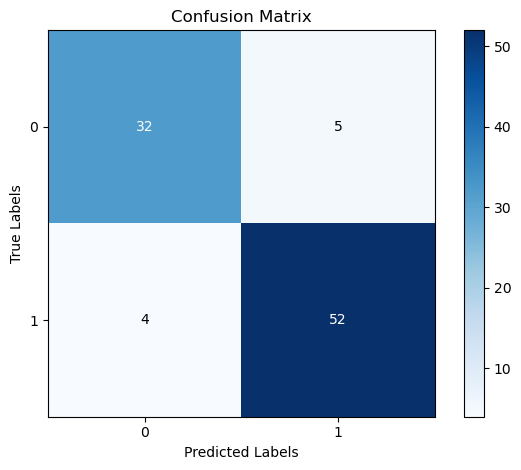

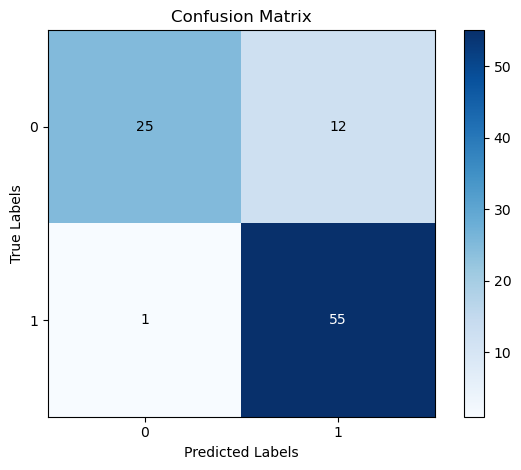

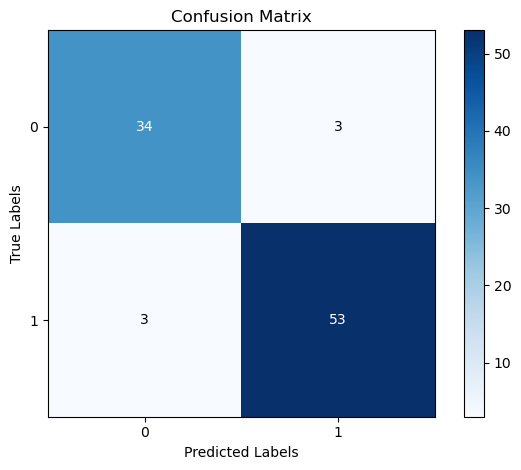

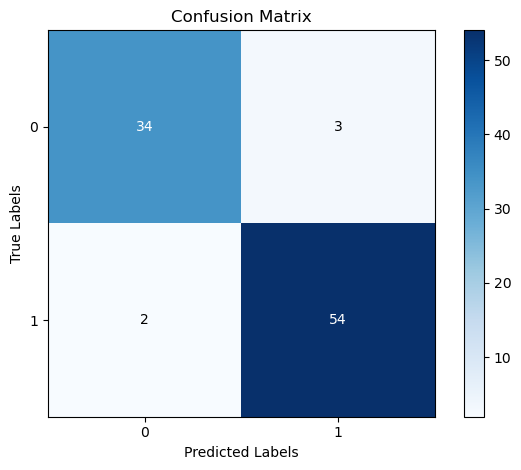

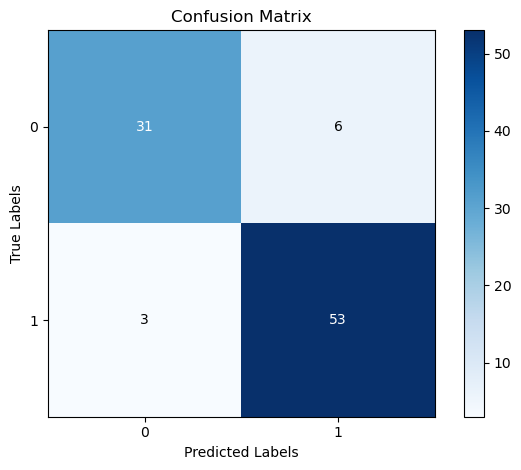

In [39]:
num_classes = 1
loss_fn = nn.BCEWithLogitsLoss()

for get_model, checkpoint_path in zip(model_functions, checkpoint_paths):
    # Load the model using the function
    loaded_model = load_model(get_model, checkpoint_path, num_classes)
    loaded_model = loaded_model.to(device)
    # Evaluate the loaded model on the test set
    print(checkpoint_path)
    evaluate_model(loaded_model, test_loader, loss_fn, checkpoint_path.split('/')[1])